In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
# first load data
train_df = pd.read_csv('data/Train-1542865627584.csv')
bene_train = pd.read_csv('data/Train_Beneficiarydata-1542865627584.csv')
inpatient_train = pd.read_csv('data/Train_Inpatientdata-1542865627584.csv')
outpatient_train = pd.read_csv('data/Train_Outpatientdata-1542865627584.csv')

In [3]:
# let pandas show all columns of a dataframe
pd.set_option('display.max_columns', None)

# I. Exploratory Data Analysis

## Provider data

In [4]:
train_df.head()

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No


In [5]:
# check the data balance
fraud_ratio = sum(train_df['PotentialFraud']=='Yes')/len(train_df)
print(f'{fraud_ratio * 100}% cases are fraudulent')
print(train_df.shape)

9.353049907578558% cases are fraudulent
(5410, 2)


**Summary:**
* The provider data only contains the provider ID and whether this provider is fradulent or not.
* The data is highly imbalanced, with fradulent class less than 10%.

## Beneficiary Details Data
This data contains beneficiary KYC details like health conditions,region they belong to etc.

In [6]:
bene_train.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [7]:
# merge state and county into one feature
bene_train['location'] = bene_train['State'].astype(str) + '-' + bene_train['County'].astype(str)

In [8]:
# combine all chronic features into one
chronic_features = ['ChronicCond_Alzheimer', 'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease', 'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression', 'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke']
bene_train['ChronicNum'] =  bene_train[chronic_features].apply(lambda x: x == 1).sum(axis=1)

In [9]:
# check whether the beneficiary is still alive. Fill the new feature with 1: dead, 0: alive
bene_train['passed away'] = ~ pd.isnull(bene_train['DOD'])
# remap it to boolean:0 --> False, 1 --> True
bene_train['passed away'] = bene_train['passed away'].map({False: 0, True: 1})

In [10]:
# remap the gender features:1-->0: male, 2-->1: female
bene_train['Gender'] = bene_train['Gender'].map({1: 0, 2: 1})

In [11]:
# remap the renal disease indicator: 'Y'-->1, '0'-->0
bene_train['RenalDiseaseIndicator'] = bene_train['RenalDiseaseIndicator'].map({'0': 0, 'Y': 1})

In [12]:
# check and remap the number of months covered and remap: 12 -->1, !12 -->0
bene_train['12Months_PartACov'] = bene_train['NoOfMonths_PartACov'].apply(lambda x: 1 if x == 12 else 0)
bene_train['12Months_PartBCov'] = bene_train['NoOfMonths_PartBCov'].apply(lambda x: 1 if x == 12 else 0)

## Inpatient Data
This data provides insights about the claims filed for those patients who are admitted in the hospitals. It also provides additional details like their admission and discharge dates and admit d diagnosis code.


In [13]:
inpatient_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [14]:
# calculate the claim duration
inpatient_train['claim_duration'] = (pd.to_datetime(inpatient_train['ClaimEndDt']) - pd.to_datetime(inpatient_train['ClaimStartDt'])).dt.days

In [15]:
# calculate the total number of claim diagnosis code
features_to_combine = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
inpatient_train['ClmDiagnosisNum'] =  inpatient_train[features_to_combine].notna().sum(axis=1)

In [16]:
# create a new feature: the total number of physicians attended
physicians = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
inpatient_train['physicianNum'] =  inpatient_train[physicians].notna().sum(axis=1)

In [17]:
# the total number of claim procedure code
features_to_combine = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']
inpatient_train['ClmProcedureNum'] =  inpatient_train[features_to_combine].notna().sum(axis=1)

In [18]:
# add a feature: Admitted to show whether this patient was admitted
inpatient_train['Admitted'] = inpatient_train['ClmAdmitDiagnosisCode'].apply(lambda x: 1 if x!='NaN' else 0)

## Outpatient Data

This data provides details about the claims filed for those patients who visit hospitals and not admitted in it.

In [19]:
outpatient_train.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
0,BENE11002,CLM624349,2009-10-11,2009-10-11,PRV56011,30,PHY326117,NaN,NaN,78943,V5866,V1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,56409
1,BENE11003,CLM189947,2009-02-12,2009-02-12,PRV57610,80,PHY362868,NaN,NaN,6115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,79380
2,BENE11003,CLM438021,2009-06-27,2009-06-27,PRV57595,10,PHY328821,NaN,NaN,2723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,BENE11004,CLM121801,2009-01-06,2009-01-06,PRV56011,40,PHY334319,NaN,NaN,71988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
4,BENE11004,CLM150998,2009-01-22,2009-01-22,PRV56011,200,PHY403831,NaN,NaN,82382,30000,72887,4280,7197,V4577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,71947


In [20]:
# calculate the claim duration
outpatient_train['claim_duration'] = (pd.to_datetime(outpatient_train['ClaimEndDt']) - pd.to_datetime(outpatient_train['ClaimStartDt'])).dt.days

In [21]:
# calculate the total number of claim diagnosis code
features_to_combine = ['ClmDiagnosisCode_1', 'ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7', 'ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10']
outpatient_train['ClmDiagnosisNum'] =  outpatient_train[features_to_combine].notna().sum(axis=1)

In [22]:
# create a new feature: the total number of physicians attended
physicians = ['AttendingPhysician', 'OperatingPhysician', 'OtherPhysician']
outpatient_train['physicianNum'] =  outpatient_train[physicians].notna().sum(axis=1)

In [23]:
# the total number of claim procedure code
features_to_combine = ['ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmProcedureCode_6']
outpatient_train['ClmProcedureNum'] =  outpatient_train[features_to_combine].notna().sum(axis=1)

In [24]:
# add a feature: Admitted to show whether this patient was admitted
outpatient_train['Admitted'] = outpatient_train['ClmAdmitDiagnosisCode'].apply(lambda x: 1 if x is not None else 0)

# II Feature engineering and dataframes merge

## combine inpatient data with beneficiary data and group by provider

In [25]:
# aggregate the inpatient data on each beneficiary-Provider pair
agg_inpatient= inpatient_train[['BeneID', 'ClaimID','Provider', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 
                                'claim_duration', 'ClmDiagnosisNum', 'physicianNum', 'ClmProcedureNum']].groupby(['BeneID','Provider']).agg(
                                {'ClaimID': 'count', 'InscClaimAmtReimbursed': 'sum', 'DeductibleAmtPaid': 'sum', 'claim_duration': 'sum', 
                                 'ClmDiagnosisNum':'sum', 'physicianNum':'sum', 'ClmProcedureNum':'sum'})

In [26]:
# combine inpatient data with beneficiary data, group by providers
inpatient_bene_df = agg_inpatient.join(bene_train.fillna(0).set_index('BeneID'), on='BeneID').reset_index()

In [27]:
inpatient_bene_df.shape

(36616, 38)

In [28]:
inpatient_bene_df.head()

,BeneID,Provider,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,claim_duration,ClmDiagnosisNum,physicianNum,ClmProcedureNum,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,location,ChronicNum,passed away,12Months_PartACov,12Months_PartBCov
0,BENE100002,PRV54894,1,12000,1068.0,25,9,2,2,1938-09-01,0,1,2,0,33,20,12,12,1,1,2,2,1,1,1,1,2,2,1,12250,1068,1760,660,33-20,7,0,1,1
1,BENE100004,PRV52890,1,3000,1068.0,2,9,2,0,1943-06-01,0,1,1,1,15,210,12,12,2,1,1,2,1,2,1,1,1,2,2,14270,2136,1880,700,15-210,6,0,1,1
2,BENE100006,PRV57317,1,17000,1068.0,6,9,2,2,1952-01-01,0,1,1,0,50,160,12,12,1,2,1,2,1,2,1,1,2,2,2,17000,1068,160,20,50-160,5,0,1,1
3,BENE100007,PRV54875,1,4000,1068.0,4,9,1,0,1939-03-01,0,0,1,1,32,240,12,12,2,2,2,2,2,2,2,1,2,2,2,4400,1068,200,140,32-240,1,0,1,1
4,BENE100010,PRV55916,2,12000,2136.0,9,18,4,1,1927-10-01,0,0,1,0,39,560,12,12,2,1,1,1,1,2,1,1,2,1,2,13400,2136,1050,760,39-560,7,0,1,1


In [29]:
# group the joined and aggregated features by Provider

inpatient_bene_prov = inpatient_bene_df[['BeneID', 'ClaimID','Provider', 
                                       'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 
                                       'claim_duration', 'ClmDiagnosisNum', 'physicianNum', 
                                       'ClmProcedureNum','RenalDiseaseIndicator','IPAnnualReimbursementAmt',
                                       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
                                       'OPAnnualDeductibleAmt', 'location', 'ChronicNum', 'passed away', 
                                       '12Months_PartACov', '12Months_PartBCov'
                                      ]].groupby(['Provider']).agg(
    {'BeneID': 'nunique', 'ClaimID': 'nunique', 'InscClaimAmtReimbursed': 'mean', 
     'DeductibleAmtPaid': 'mean', 'claim_duration': 'mean', 'ClmDiagnosisNum':'mean', 
     'physicianNum':'mean', 'ClmProcedureNum':'mean','RenalDiseaseIndicator':'sum', 
     'IPAnnualReimbursementAmt':'mean', 'IPAnnualDeductibleAmt': 'mean','OPAnnualReimbursementAmt':'mean',
     'OPAnnualDeductibleAmt':'mean', 'location':'nunique', 'ChronicNum':'mean', 'passed away':'sum', 
     '12Months_PartACov':'mean', '12Months_PartBCov':'mean'
     })

In [30]:
inpatient_bene_prov.head()

,BeneID,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,claim_duration,ClmDiagnosisNum,physicianNum,ClmProcedureNum,RenalDiseaseIndicator,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,location,ChronicNum,passed away,12Months_PartACov,12Months_PartBCov
Provider,,,,,,,,,,,,,,,,,,
PRV51001,5,1,19400.000000,1068.000000,5.000000,7.200000,1.600000,0.600000,2,77902.00000,2563.200000,1350.000000,236.00000,2,6.000000,0,1.000000,1.000000
PRV51003,53,3,10811.320755,1249.358491,6.037736,9.490566,1.924528,0.905660,12,11925.09434,1473.433962,1751.698113,584.90566,13,4.679245,1,0.981132,0.981132
PRV51007,3,1,6333.333333,1068.000000,5.333333,7.333333,1.333333,0.333333,1,11710.00000,2136.000000,2413.333333,470.00000,1,5.666667,0,1.000000,1.000000
PRV51008,2,1,12500.000000,1068.000000,4.000000,7.500000,2.000000,1.000000,0,18750.00000,1602.000000,320.000000,165.00000,1,3.500000,0,1.000000,1.000000
PRV51011,1,1,5000.000000,1068.000000,5.000000,8.000000,1.000000,0.000000,1,5000.00000,1068.000000,590.000000,90.00000,1,7.000000,0,1.000000,1.000000


In [31]:
inpatient_bene_prov.shape

(2092, 18)

In [32]:
# before combine agg_outpatient, for each aggregated inpatient feature, add prefix "In_" to distinguish with outpatient data
for feature in inpatient_bene_prov.columns[:]:
    inpatient_bene_prov.rename(columns={feature: 'In_'+feature}, inplace=True)

## combine outpatient data with beneficiary data and group by Provider

In [33]:
# aggregate the inpatient data on each beneficiary-Provider pair
agg_outpatient= outpatient_train[['BeneID', 'ClaimID','Provider', 'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 
                                  'claim_duration', 'ClmDiagnosisNum', 'physicianNum', 'ClmProcedureNum']].groupby(['BeneID','Provider']).agg(
                                {'ClaimID': 'count', 'InscClaimAmtReimbursed': 'sum', 'DeductibleAmtPaid': 'sum', 
                                 'claim_duration': 'sum', 'ClmDiagnosisNum':'sum', 'physicianNum':'sum', 'ClmProcedureNum':'sum'})

In [34]:
# join agg_outpatient with beneficiary 
outpatient_bene_df = agg_outpatient.join(bene_train.fillna(0).set_index('BeneID'), on='BeneID').reset_index()

In [35]:
# group by providers
outpatient_bene_prov = outpatient_bene_df[['BeneID', 'ClaimID','Provider', 
                                       'InscClaimAmtReimbursed', 'DeductibleAmtPaid', 
                                       'claim_duration', 'ClmDiagnosisNum', 'physicianNum', 
                                       'ClmProcedureNum','RenalDiseaseIndicator','IPAnnualReimbursementAmt',
                                       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
                                       'OPAnnualDeductibleAmt', 'location', 'ChronicNum', 'passed away', 
                                       '12Months_PartACov', '12Months_PartBCov'
                                      ]].groupby(['Provider']).agg(
    {'BeneID': 'nunique', 'ClaimID': 'nunique', 'InscClaimAmtReimbursed': 'mean', 
     'DeductibleAmtPaid': 'mean', 'claim_duration': 'mean', 'ClmDiagnosisNum':'mean', 
     'physicianNum':'mean', 'ClmProcedureNum':'mean','RenalDiseaseIndicator':'sum', 
     'IPAnnualReimbursementAmt':'mean', 'IPAnnualDeductibleAmt': 'mean','OPAnnualReimbursementAmt':'mean',
     'OPAnnualDeductibleAmt':'mean', 'location':'nunique', 'ChronicNum':'mean', 'passed away':'sum', 
     '12Months_PartACov':'mean', '12Months_PartBCov':'mean'
     })

In [36]:
outpatient_bene_prov.shape

(5012, 18)

In [37]:
outpatient_bene_prov.head()

,BeneID,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,claim_duration,ClmDiagnosisNum,physicianNum,ClmProcedureNum,RenalDiseaseIndicator,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,location,ChronicNum,passed away,12Months_PartACov,12Months_PartBCov
Provider,,,,,,,,,,,,,,,,,,
PRV51001,19,2,402.105263,0.000000,0.578947,2.315789,1.684211,0.0,6,2296.842105,449.684211,2850.000000,537.789474,6,5.421053,0,1.000000,1.000000
PRV51003,66,2,495.000000,1.060606,2.500000,2.878788,1.515152,0.0,11,2800.151515,339.818182,3045.757576,735.606061,23,4.257576,0,0.984848,0.984848
PRV51004,138,4,378.043478,2.246377,1.543478,2.789855,1.731884,0.0,20,4596.739130,454.144928,2095.144928,600.869565,33,4.318841,1,0.978261,0.992754
PRV51005,495,15,567.494949,7.474747,2.561616,6.092929,3.763636,0.0,79,3717.232323,398.698990,1798.808081,475.965657,27,3.884848,3,0.985859,0.985859
PRV51007,56,3,262.678571,1.071429,0.946429,3.446429,1.892857,0.0,9,2825.535714,362.357143,1447.857143,436.785714,6,3.821429,1,0.982143,0.982143


In [38]:
# for each aggregated outpatient feature, add prefix "Ot_" to distinguish with inpatient data
for feature in outpatient_bene_prov.columns[:]:
    outpatient_bene_prov.rename(columns={feature: 'Ot_'+feature}, inplace=True)

## join outpatient data with inpatient data of the same provider

In [39]:
# left join inpatient data with beneficiary data
final_features = outpatient_bene_prov.merge(inpatient_bene_prov, how='left', on='Provider')

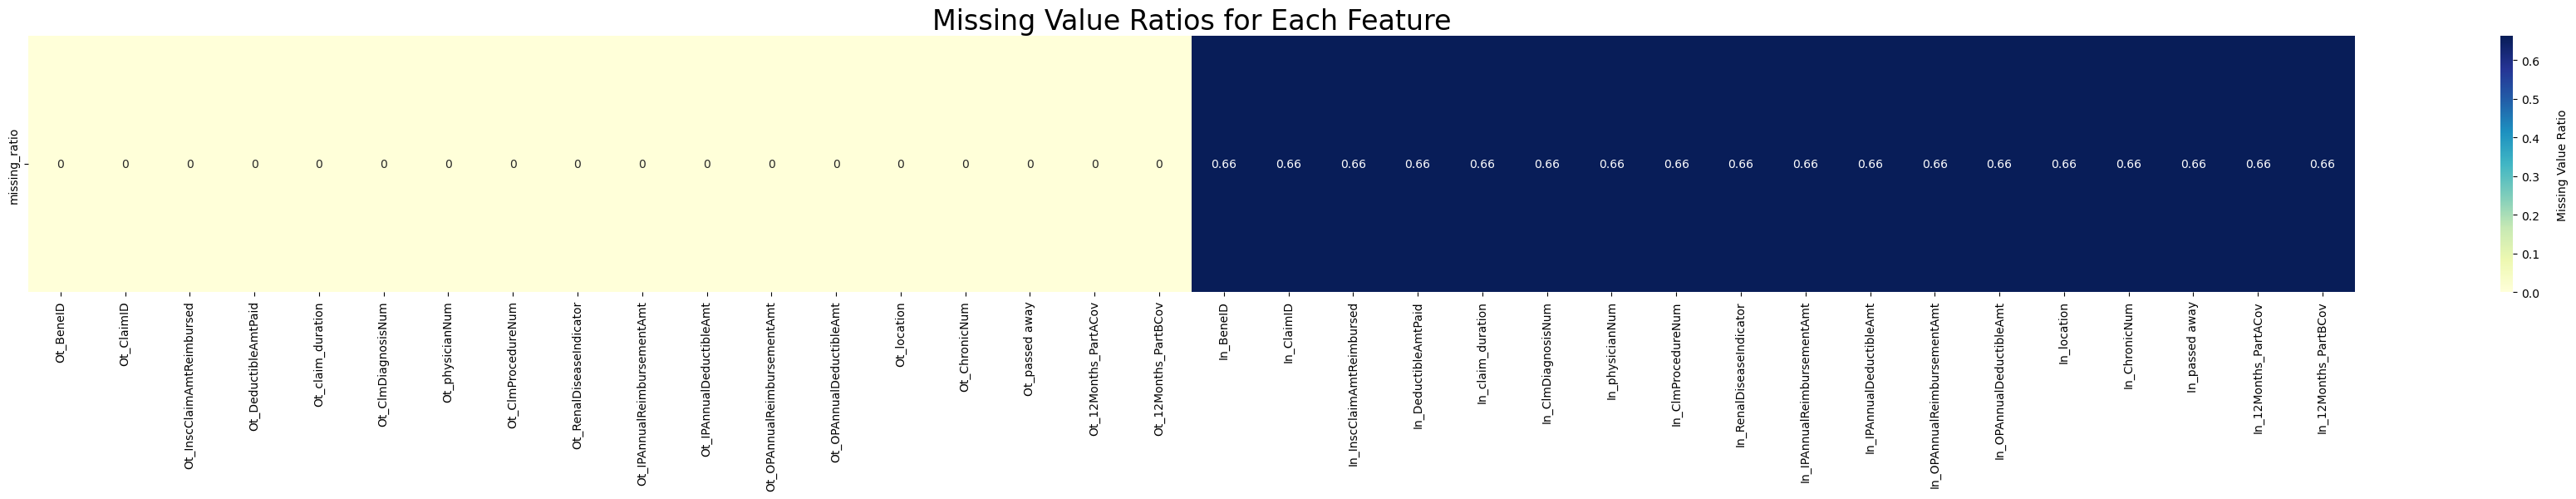

In [40]:
# check missing values 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# check null values ratio
missing_values_count = final_features.isna().sum()

# Calculate the ratio of missing values
missing_values_ratio = missing_values_count / len(final_features)

# Convert the ratio to a DataFrame for the heatmap
missing_values_df = pd.DataFrame(missing_values_ratio, columns=['missing_ratio']).T

# Plotting the heatmap
plt.figure(figsize=(50, 4))
ax=sns.heatmap(missing_values_df, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Missing Value Ratio'})
plt.title('Missing Value Ratios for Each Feature', fontsize=24)
# plt.ylabel('Features', fontsize=20)

plt.subplots_adjust(left=0.15, right=0.85)
cbar = ax.collections[0].colorbar
cbar.set_label('Missing Value Ratio', labelpad=15)
cbar.ax.yaxis.set_label_position('right')

plt.show()

In [41]:
# fill all missing values with 0
final_features = final_features.fillna(0)

## combine with potential fraud data to form the final dataset

In [42]:
full_data = final_features.merge(train_df, on = 'Provider')
full_data.head()

,Provider,Ot_BeneID,Ot_ClaimID,Ot_InscClaimAmtReimbursed,Ot_DeductibleAmtPaid,Ot_claim_duration,Ot_ClmDiagnosisNum,Ot_physicianNum,Ot_ClmProcedureNum,Ot_RenalDiseaseIndicator,Ot_IPAnnualReimbursementAmt,Ot_IPAnnualDeductibleAmt,Ot_OPAnnualReimbursementAmt,Ot_OPAnnualDeductibleAmt,Ot_location,Ot_ChronicNum,Ot_passed away,Ot_12Months_PartACov,Ot_12Months_PartBCov,In_BeneID,In_ClaimID,In_InscClaimAmtReimbursed,In_DeductibleAmtPaid,In_claim_duration,In_ClmDiagnosisNum,In_physicianNum,In_ClmProcedureNum,In_RenalDiseaseIndicator,In_IPAnnualReimbursementAmt,In_IPAnnualDeductibleAmt,In_OPAnnualReimbursementAmt,In_OPAnnualDeductibleAmt,In_location,In_ChronicNum,In_passed away,In_12Months_PartACov,In_12Months_PartBCov,PotentialFraud
0,PRV51001,19,2,402.105263,0.000000,0.578947,2.315789,1.684211,0.0,6,2296.842105,449.684211,2850.000000,537.789474,6,5.421053,0,1.000000,1.000000,5.0,1.0,19400.000000,1068.000000,5.000000,7.200000,1.600000,0.600000,2.0,77902.00000,2563.200000,1350.000000,236.00000,2.0,6.000000,0.0,1.000000,1.000000,No
1,PRV51003,66,2,495.000000,1.060606,2.500000,2.878788,1.515152,0.0,11,2800.151515,339.818182,3045.757576,735.606061,23,4.257576,0,0.984848,0.984848,53.0,3.0,10811.320755,1249.358491,6.037736,9.490566,1.924528,0.905660,12.0,11925.09434,1473.433962,1751.698113,584.90566,13.0,4.679245,1.0,0.981132,0.981132,Yes
2,PRV51004,138,4,378.043478,2.246377,1.543478,2.789855,1.731884,0.0,20,4596.739130,454.144928,2095.144928,600.869565,33,4.318841,1,0.978261,0.992754,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,No
3,PRV51005,495,15,567.494949,7.474747,2.561616,6.092929,3.763636,0.0,79,3717.232323,398.698990,1798.808081,475.965657,27,3.884848,3,0.985859,0.985859,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.000000,Yes
4,PRV51007,56,3,262.678571,1.071429,0.946429,3.446429,1.892857,0.0,9,2825.535714,362.357143,1447.857143,436.785714,6,3.821429,1,0.982143,0.982143,3.0,1.0,6333.333333,1068.000000,5.333333,7.333333,1.333333,0.333333,1.0,11710.00000,2136.000000,2413.333333,470.00000,1.0,5.666667,0.0,1.000000,1.000000,No


In [43]:
# replace the 'Yes' and 'No' in data labels with 1 and 0 for subsequent classification
full_data['PotentialFraud'].replace(('Yes', 'No'), (1, 0), inplace=True)

In [44]:
# transform the only categorical feature (provider) to category
full_data['Provider'] =full_data['Provider'].astype("category")

In [45]:
# check the columns in final dataset
full_data.columns

Index(['Provider', 'Ot_BeneID', 'Ot_ClaimID', 'Ot_InscClaimAmtReimbursed',
       'Ot_DeductibleAmtPaid', 'Ot_claim_duration', 'Ot_ClmDiagnosisNum',
       'Ot_physicianNum', 'Ot_ClmProcedureNum', 'Ot_RenalDiseaseIndicator',
       'Ot_IPAnnualReimbursementAmt', 'Ot_IPAnnualDeductibleAmt',
       'Ot_OPAnnualReimbursementAmt', 'Ot_OPAnnualDeductibleAmt',
       'Ot_location', 'Ot_ChronicNum', 'Ot_passed away',
       'Ot_12Months_PartACov', 'Ot_12Months_PartBCov', 'In_BeneID',
       'In_ClaimID', 'In_InscClaimAmtReimbursed', 'In_DeductibleAmtPaid',
       'In_claim_duration', 'In_ClmDiagnosisNum', 'In_physicianNum',
       'In_ClmProcedureNum', 'In_RenalDiseaseIndicator',
       'In_IPAnnualReimbursementAmt', 'In_IPAnnualDeductibleAmt',
       'In_OPAnnualReimbursementAmt', 'In_OPAnnualDeductibleAmt',
       'In_location', 'In_ChronicNum', 'In_passed away',
       'In_12Months_PartACov', 'In_12Months_PartBCov', 'PotentialFraud'],
      dtype='object')

# III Modeling and Prediction

## split data into training and testing set

In [46]:
from sklearn.model_selection import train_test_split
# since the Provider feature is unique, it won't contribute too much to the training. 
X = full_data.drop(['Provider','PotentialFraud'], axis=1)
y = full_data['PotentialFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

print(f"training set size: {X_train.shape}, testing set size: {X_test.shape}")

training set size: (4009, 36), testing set size: (1003, 36)


In [47]:
# check the fradulent ratio for each dataset
train_fraud = sum(y_train==1)/len(y_train)
test_fraud = sum(y_test==1)/len(y_test)

print(f"training set fraud ratio: {train_fraud}")
print(f"testing set fraud ratio: {test_fraud}")      

training set fraud ratio: 0.09329009728111748
testing set fraud ratio: 0.08773678963110668


In [48]:
# apply SMOTE only on training set
import sklearn
from imblearn.over_sampling import SMOTE
from collections import Counter

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("After oversampling: ", Counter(y_train_smote))

After oversampling:  Counter({0: 3635, 1: 3635})


## Logistic regression

C:\Users\xq\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


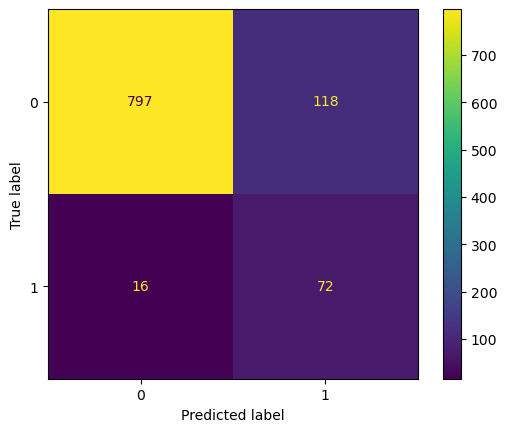

Accuracy: 0.8664007976071785
Confusion Matrix:
[[797 118]
 [ 16  72]]


In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize and fit the logistic regression model
log_reg = LogisticRegression(max_iter=500)  # Increasing max_iter for convergence
log_reg.fit(X_train_smote, y_train_smote)

# Make predictions
log_pred = log_reg.predict(X_test)
log_prob = log_reg.predict_proba(X_test)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_test, log_pred)
conf_matrix = confusion_matrix(y_test, log_pred, labels=log_reg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg.classes_)
disp.plot()
plt.show()
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


## Random Forest

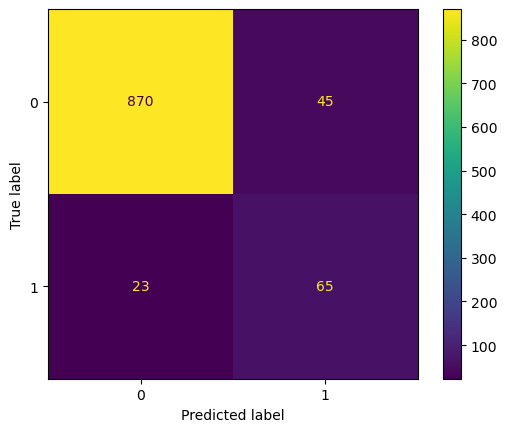

Accuracy: 0.9322033898305084
Confusion Matrix:
[[870  45]
 [ 23  65]]


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42) 

# Fit the model on the training data
random_forest.fit(X_train_smote, y_train_smote)

# Make predictions on the testing set
rf_pred = random_forest.predict(X_test)
rf_prob = random_forest.predict_proba(X_test)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_test, rf_pred)
conf_matrix = confusion_matrix(y_test, rf_pred,labels=random_forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=random_forest.classes_)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


## XGBoost

In [51]:
import sys
!{sys.executable} -m pip install xgboost

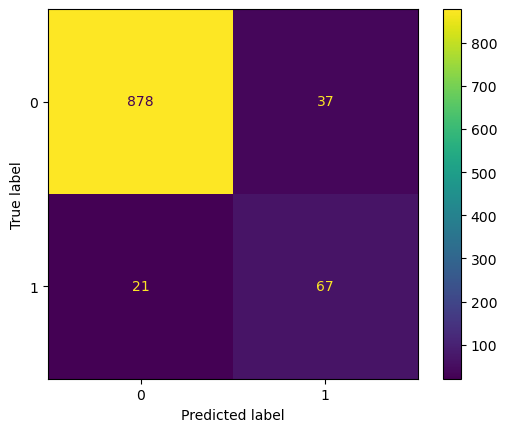

Test Accuracy: 0.942173479561316
Confusion Matrix:
[[878  37]
 [ 21  67]]


In [52]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize the XGBoost classifier
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, enable_categorical=True, eval_metric='logloss')

# Fit the model
xgb_clf.fit(X_train_smote, y_train_smote)
xgb_pred = xgb_clf.predict(X_test)
xgb_prob = xgb_clf.predict_proba(X_test)[:,1]

test_accuracy = accuracy_score(y_test, xgb_pred)
conf_matrix = confusion_matrix(y_test, xgb_pred, labels=xgb_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_clf.classes_)
disp.plot()
plt.show()

print(f"Test Accuracy: {test_accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


## KNN

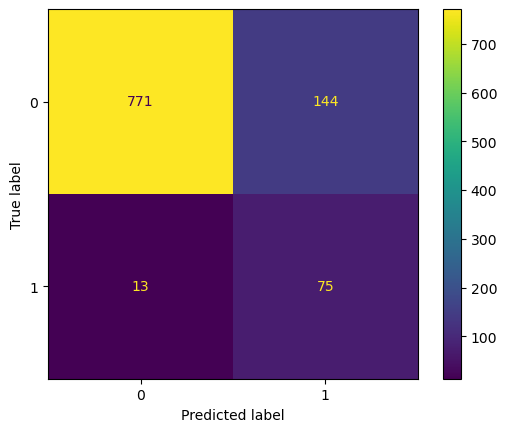

Accuracy: 0.843469591226321
Confusion Matrix:
[[771 144]
 [ 13  75]]


In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Initialize the KNN classifier
# n_neighbors is the number of neighbors to consider; you can adjust this based on your dataset
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Fit the model on the training data
knn.fit(X_train_smote, y_train_smote)

# Make predictions on the testing set
knn_pred = knn.predict(X_test)
knn_prob = knn.predict_proba(X_test)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_test, knn_pred)
conf_matrix = confusion_matrix(y_test, knn_pred, labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=knn.classes_)
disp.plot()
plt.show()

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


## LightGBM

In [54]:
import sys
!{sys.executable} -m pip install lightgbm

In [55]:
# may need to update some packages before running lighGBM
!{sys.executable} -m pip install tabgan==1.3.3

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: ba

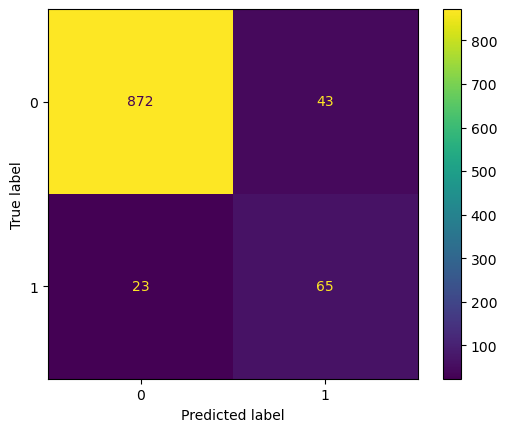

Accuracy: 0.93419740777667
Confusion Matrix:
[[872  43]
 [ 23  65]]


In [56]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define parameters (can be tuned for better performance)

gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective='binary',
                         metric='binary_logloss',
                         num_leaves=31,
                         learning_rate=0.05,
                         feature_fraction=0.9,
                         bagging_fraction=0.8,
                         bagging_freq=5,
                         verbose=0,
                         n_estimators=100)  # n_estimators corresponds to num_boost_round


# Fit the model on the training data
gbm.fit(X_train_smote, y_train_smote, eval_set=[(X_test, y_test)])

# Predict class labels for the test set
y_pred_binary = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

# Predict probabilities for the test set
gbm_prob = gbm.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary,labels=gbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=gbm.classes_)
disp.plot()
plt.show()


print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


## Plot ROC-AUC curve

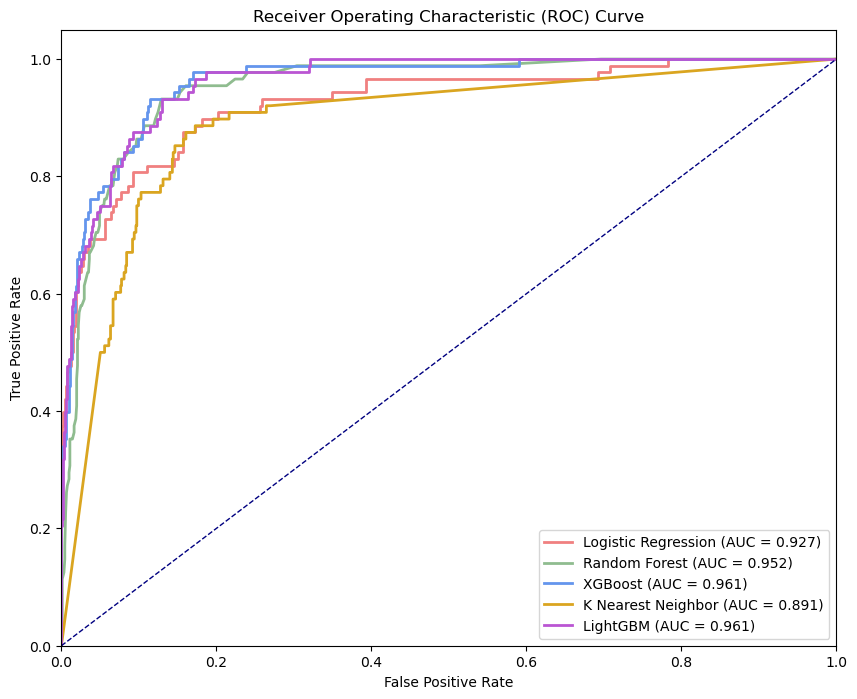

In [57]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve points
fpr_log, tpr_log, _ = roc_curve(y_test, log_prob)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob)
fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_prob)
fpr_gbm, tpr_gbm, _ = roc_curve(y_test, gbm_prob)


# Calculate the AUC (Area under the ROC Curve)
roc_auc_log = auc(fpr_log, tpr_log)
roc_auc_rf = auc(fpr_rf, tpr_rf)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
roc_auc_knn = auc(fpr_knn, tpr_knn)
roc_auc_gbm = auc(fpr_gbm, tpr_gbm)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, color='lightcoral', lw=2, label=f'Logistic Regression (AUC = {roc_auc_log:.3f})')
plt.plot(fpr_rf, tpr_rf, color='darkseagreen', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, color='cornflowerblue', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.3f})')
plt.plot(fpr_knn, tpr_knn, color='goldenrod', lw=2, label=f'K Nearest Neighbor (AUC = {roc_auc_knn:.3f})')
plt.plot(fpr_gbm, tpr_gbm, color='mediumorchid', lw=2, label=f'LightGBM (AUC = {roc_auc_gbm:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Plot Precision-recall curve

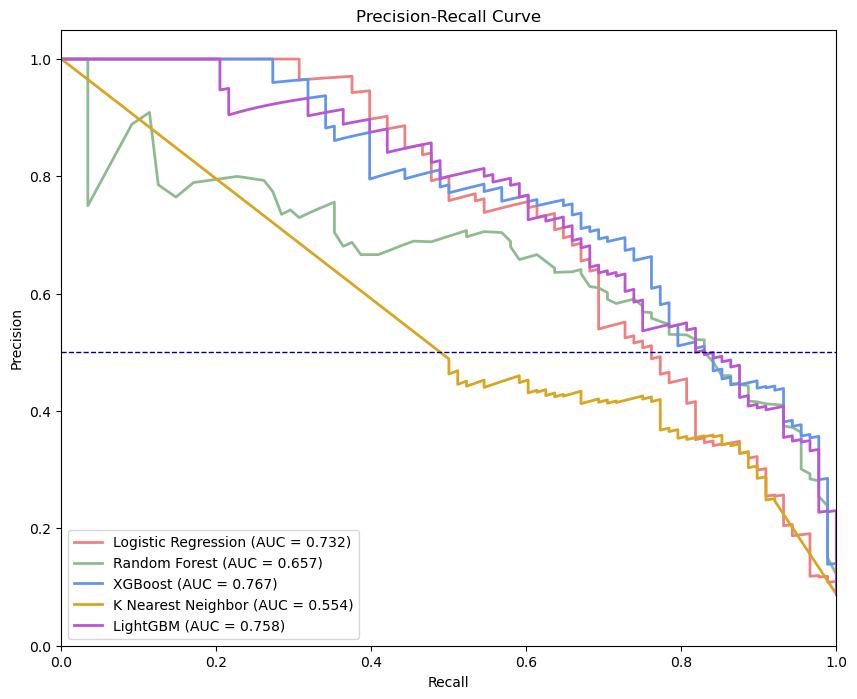

In [58]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test is your true labels and you have prediction probabilities for your models
# probas_logreg = log_reg.predict_proba(X_test)[:,1]  # Logistic Regression probabilities
# probas_rf = random_forest.predict_proba(X_test)[:,1]  # Random Forest probabilities
# probas_lgbm = gbm.predict(X_test)  # LightGBM probabilities, if using binary classification

# Calculate Precision-Recall curve points
precision_log, recall_log, _ = precision_recall_curve(y_test, log_prob)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_prob)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, knn_prob)
precision_gbm, recall_gbm, _ = precision_recall_curve(y_test, gbm_prob)

# Calculate the AUC for Precision-Recall Curve
auc_pr_log = auc(recall_log, precision_log)
auc_pr_rf = auc(recall_rf, precision_rf)
auc_pr_xgb = auc(recall_xgb, precision_xgb)
auc_pr_knn = auc(recall_knn, precision_knn)
auc_pr_gbm = auc(recall_gbm, precision_gbm)

# Plotting
plt.figure(figsize=(10, 8))
plt.plot(recall_log, precision_log, color='lightcoral', lw=2, label=f'Logistic Regression (AUC = {auc_pr_log:.3f})')
plt.plot(recall_rf, precision_rf, color='darkseagreen', lw=2, label=f'Random Forest (AUC = {auc_pr_rf:.3f})')
plt.plot(recall_xgb, precision_xgb, color='cornflowerblue', lw=2, label=f'XGBoost (AUC = {auc_pr_xgb:.3f})')
plt.plot(recall_knn, precision_knn, color='goldenrod', lw=2, label=f'K Nearest Neighbor (AUC = {auc_pr_knn:.3f})')
plt.plot(recall_gbm, precision_gbm, color='mediumorchid', lw=2, label=f'LightGBM (AUC = {auc_pr_gbm:.3f})')

plt.plot([0, 1], [0.5, 0.5], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


## which features contributed the most to the prediciton model?

In [59]:
!{sys.executable} -m pip install shap

In [90]:
# shap analysis function
import shap
def shap_plot(clf, features):
    shap.initjs()
    model = clf
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(features)
    # visualize the impact of each features
    shap.summary_plot(shap_values, features)

## XGBoost

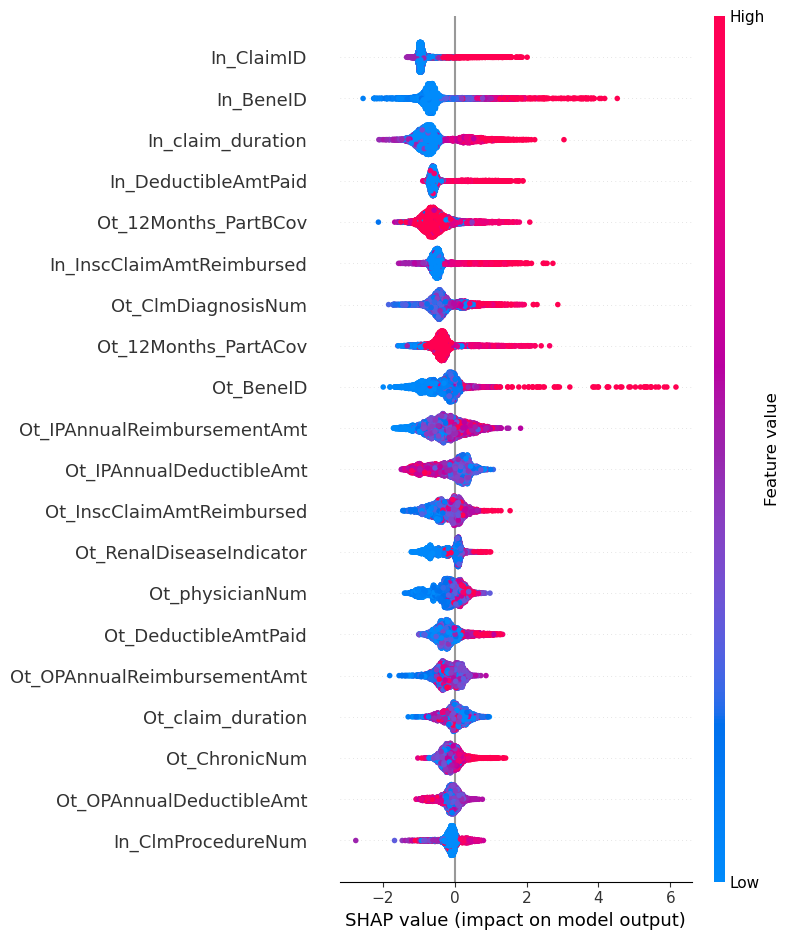

In [91]:
shap_plot(xgb_clf, final_features)

## lightGBM

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


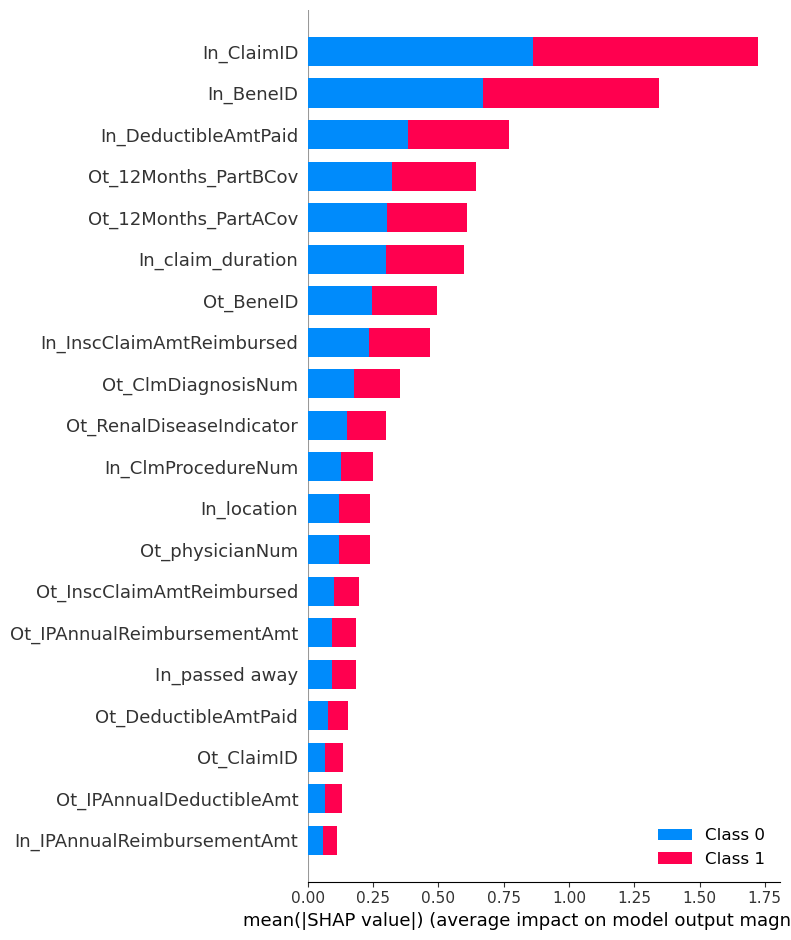

In [62]:
shap_plot(gbm, final_features)

## Random Forest

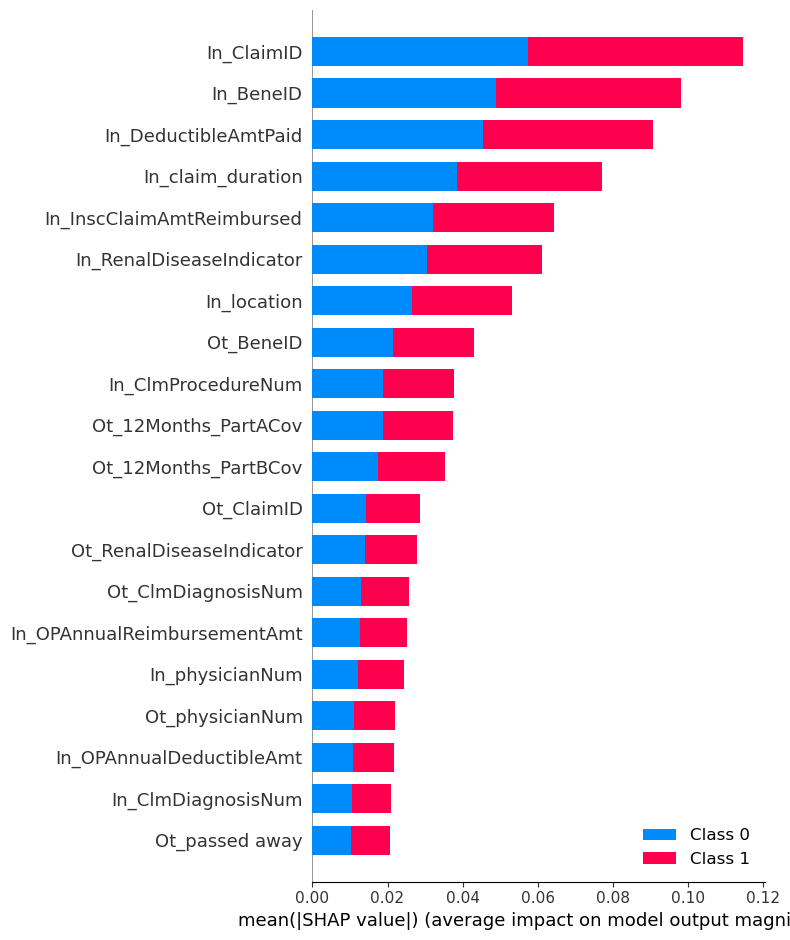

In [63]:
shap_plot(random_forest, final_features)

## Logistic Regression

In [64]:
# calculate feature importance for non-tree-based model
def calculate_importance(features, model):
    coefficients = model.coef_[0]
    feature_importance = pd.DataFrame({'Feature': features.columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=True)
    feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
    plt.show()

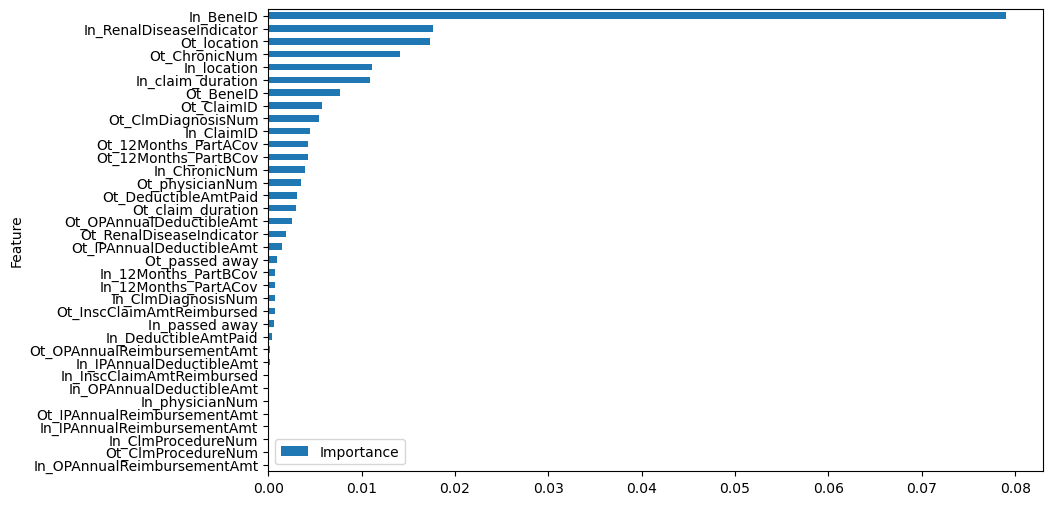

In [65]:
calculate_importance(final_features, log_reg)

With this set, retrain a xgboost model with the first 8 contributive features for online prediction

In [67]:
X_train.columns

Index(['Ot_BeneID', 'Ot_ClaimID', 'Ot_InscClaimAmtReimbursed',
       'Ot_DeductibleAmtPaid', 'Ot_claim_duration', 'Ot_ClmDiagnosisNum',
       'Ot_physicianNum', 'Ot_ClmProcedureNum', 'Ot_RenalDiseaseIndicator',
       'Ot_IPAnnualReimbursementAmt', 'Ot_IPAnnualDeductibleAmt',
       'Ot_OPAnnualReimbursementAmt', 'Ot_OPAnnualDeductibleAmt',
       'Ot_location', 'Ot_ChronicNum', 'Ot_passed away',
       'Ot_12Months_PartACov', 'Ot_12Months_PartBCov', 'In_BeneID',
       'In_ClaimID', 'In_InscClaimAmtReimbursed', 'In_DeductibleAmtPaid',
       'In_claim_duration', 'In_ClmDiagnosisNum', 'In_physicianNum',
       'In_ClmProcedureNum', 'In_RenalDiseaseIndicator',
       'In_IPAnnualReimbursementAmt', 'In_IPAnnualDeductibleAmt',
       'In_OPAnnualReimbursementAmt', 'In_OPAnnualDeductibleAmt',
       'In_location', 'In_ChronicNum', 'In_passed away',
       'In_12Months_PartACov', 'In_12Months_PartBCov'],
      dtype='object')

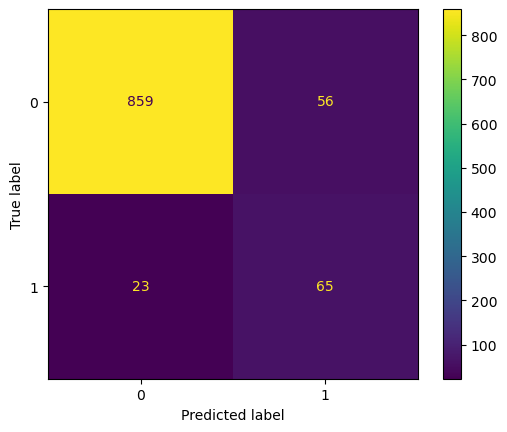

Test Accuracy: 0.9212362911266201
Confusion Matrix:
[[859  56]
 [ 23  65]]


In [68]:
# truncate the features
X_train_truncated = X_train_smote[['In_ClaimID', 'In_BeneID', 'In_claim_duration', 'In_DeductibleAmtPaid', 
                                  'Ot_12Months_PartBCov', 'In_InscClaimAmtReimbursed', 'Ot_ClmDiagnosisNum',
                                  'Ot_12Months_PartACov']]

X_test_truncated = X_test[['In_ClaimID', 'In_BeneID', 'In_claim_duration', 'In_DeductibleAmtPaid', 
                                  'Ot_12Months_PartBCov', 'In_InscClaimAmtReimbursed', 'Ot_ClmDiagnosisNum',
                                  'Ot_12Months_PartACov']]

# Initialize the XGBoost classifier
xgb_t = xgb.XGBClassifier(use_label_encoder=False, enable_categorical=True, eval_metric='logloss')

# Fit the model
xgb_t.fit(X_train_truncated, y_train_smote)
xgb_pred = xgb_t.predict(X_test_truncated)
xgb_prob = xgb_t.predict_proba(X_test_truncated)[:,1]

test_accuracy = accuracy_score(y_test, xgb_pred)
conf_matrix = confusion_matrix(y_test, xgb_pred, labels=xgb_t.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=xgb_t.classes_)
disp.plot()
plt.show()

print(f"Test Accuracy: {test_accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")


In [70]:
# wrap the model into a pickle file
import pickle
file = open('xgboost_model.pkl', 'wb')
pickle.dump(xgb_t, file)